# Key Factors Influencing Player Market Value

## 1. Introduction

The purpose of this analysis is to **identify the key features** that most significantly influence a player's market value (`value_eur`). By combining **correlation analysis** with **advanced machine learning techniques**, I aim to validate and highlight the most informative attributes that contribute to determining a player's worth in the market. This approach ensures a **comprehensive understanding** of the factors driving player valuations.

## 2. Key Findings Summary

- **Overall Skill Rating** and **Potential** are the most significant predictors of a player's market value. These features exhibit the **strongest correlations** and are consistently highlighted as key factors by both the correlation analysis and the machine learning model.

- **Skill Score** and **Potential Chance** play **supportive roles** in estimating market value. While not as influential as Overall Skill and Potential, these features contribute moderately to the player's valuation.

- **Contract Duration** shows a **minor but noteworthy influence** on market value. Players with longer contracts tend to have slightly higher market values, indicating the importance of contract stability in player valuation.

## 3. Correlation Analysis

### Graph: Heatmap of Correlation Matrix

Below is a heatmap showing the correlation matrix of various features with the market value. This visual representation helps identify which features are strongly correlated with the player's market value.

In [1]:
#Import for data processing and vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# Import for ML
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# File path to the CSV data
file_path = r'C:\Users\mryok\OneDrive\Рабочий стол\New folder\df_players_cleaned.csv'
df_cleaned = pd.read_csv(file_path,header=0,index_col=0)
# Display the first few rows of the dataframe
# df_cleaned.head()

*Figure 1: Correlation Matrix Showing Relationships Between Features and Market Value*

The heatmap visually confirms that **Overall Skill Rating** and **Potential** are the most influential features, while **Contract Duration** has a lesser impact. This supports our earlier findings and provides a clear picture of how different attributes relate to market value.

In [2]:
# Calculate correlation matrix
correlation_matrix = df_cleaned.corr()
# Calculate feature correlation with target (value_eur)
feature_target_correlation = correlation_matrix['value_eur'].drop('value_eur')
# Calculate absolute correlation values
feature_target_correlation_abs = feature_target_correlation.abs().sort_values(ascending=False)

print(feature_target_correlation_abs)

# Heatmap of correlation matrix
fig_heatmap = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='Viridis',
    colorbar=dict(title='Correlation')
))
fig_heatmap.update_layout(
    title='Correlation Matrix',
    xaxis_title='Features',
    yaxis_title='Features'
)
fig_heatmap.show()

# Bar plot for feature correlation with target
fig_bar = px.bar(
    x=feature_target_correlation_abs.values,
    y=feature_target_correlation_abs.index,
    labels={'x': 'Absolute Correlation', 'y': 'Feature'},
    title='Feature Correlation with Target (value_eur)',
    color=feature_target_correlation_abs.values,
    color_continuous_scale='Viridis'
)
fig_bar.update_layout(
    xaxis_title='Absolute Correlation',
    yaxis_title='Feature',
    title_x=0.5
)
fig_bar.show()

overall                      0.651181
potential                    0.626917
skill_score                  0.464968
potential_chance             0.289667
club_contract_valid_until    0.285997
physic                       0.190647
age_category                 0.041230
bmi                          0.014266
club_name                    0.014084
formation                    0.000373
Name: value_eur, dtype: float64


## Summary

- **Strong Positive Correlations**: Features such as **Overall Skill Rating** and **Potential** are strongly related to market value, indicating their **significant influence** on a player’s valuation.

- **Moderate Positive Correlations**: **Skill Score** shows a moderate correlation with market value, while **Potential Chance** and **Contract Duration** have a weaker but noticeable impact.

- **Weak Correlations**: Features such as **Physic** and **Age Category** have weak correlations with market value, meaning their impact is **minor** compared to skill-related features.

- **Negligible Correlations**: Features such as **BMI**, **Club Name**, and **Formation** have negligible correlations, indicating they have **little to no effect** on market value.

## 4. Determining Feature Importance Using Machine Learning

To understand which factors are most important in predicting a player’s market value, a machine learning approach with a **XGBoost** was used. Here are step by step actions:

- **Preparing the Data**: divided the data into two groups: one for **training** the model and one for **testing** it. This helps ensure that our model learns effectively and is evaluated on new data.

- **Optimizing the Model**: fine-tuned the model by trying different settings and selecting the ones that provided the best performance.

- **Identifying Important Features**: after training, I analyzed which features (such as skill level, potential, etc.) most strongly influence the player's market value.

- **Visualizing Results**: **bar chart** was used to clearly display which features are most important for predicting a player’s worth.

This process helps us pinpoint the **key factors** in determining a player’s market value, allowing us to focus on what really matters.

**Figure 2: Feature Importance for Estimating Player Value with XGBoost**


In [3]:
X = df_cleaned.drop('value_eur', axis=1)  # Features
y = df_cleaned['value_eur']               # Target
# Handle categorical features (if any) - Example with one-hot encoding
X = pd.get_dummies(X)
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
# Initialize the XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
# Get the best parameters from Grid Search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Train the XGBoost with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train_scaled, y_train)
# Get feature importances
importances = best_xgb_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_importance_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values
})
fig_importances = px.bar(
    feature_importance_df, 
    x='Importance', 
    y='Feature', 
    title='Feature Importance for Estimating Player Value with XGBoost',
    labels={'Importance': 'Importance', 'Feature': 'Feature'},
    orientation='h',
    height=600,
    width=800
)
fig_importances.show()

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


This bar plot illustrates the **relative importance** of various features in predicting player market value, as determined by the XGBoost model. The results **confirm** the findings from our correlation analysis, highlighting **Overall Skill Rating** and **Potential** as the most influential factors. The model's feature importance ranking aligns with earlier observations, reinforcing that these attributes are **crucial** for estimating a player’s market value.

## 5. Explanation with the SHAP Summary Plot

### Purpose of the SHAP Summary Plot

- The SHAP summary plot provides **insights** into how various factors (features) influence the predictions made by our model. In this context, it helps us understand the drivers behind the estimated market value of football players in our dataset.

### Key Components of the Plot

- **Feature Names**: The plot displays different factors or features that impact player value, such as age, overall skill rating, and potential.

- **Impact of Features**: Each feature is represented with a spread of colors and points. The position of these points along the horizontal axis indicates whether a feature increases or decreases the predicted market value and to what extent.

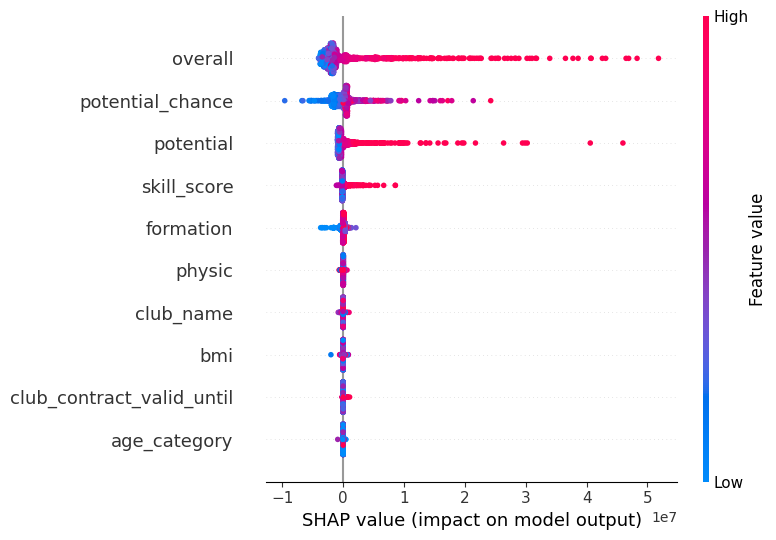

In [4]:
# Train XGBoost model
model = xgb.XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)
# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)
# Compute SHAP values
shap_values = explainer(X_test)
# Plot summary
shap.summary_plot(shap_values, X_test)

### Explanation

From the SHAP summary plot, it is confirmed the findings from the correlation analysis. Features such as **"Overall" Skill Rating** and **"Potential"** have the most significant impact on determining a player's market value. In addition, **"Potential Chance"**, **"Skill Score"**, and **"Formation"** also have a moderate effect on the predicted value.

Conversely, other features like **"Club Name"** and **"BMI"** show minimal influence on market value predictions. Therefore, when building a machine learning model for price prediction, focusing on factors related to **Potential**, **Overall Skill**, and **Skill Score** will be most effective. Features with minor impact should be considered supplementary rather than central to the model.

## 6. Conclusion

The analysis identified that **Overall Skill Rating** and **Potential** are the most important factors in estimating a player's market value. These features have the **strongest influence** on a player’s worth, as both correlation analysis and machine learning techniques have consistently highlighted their significance. Additionally, **Skill Score** and **Potential Chance** also play a noteworthy role, while **Contract Duration** has a minor but relevant impact.

### Recommendations

For optimal player valuation and strategic decision-making, the management team should focus on scouting players with high **Overall Skill Ratings** and strong **Potential**. Emphasizing these attributes will provide a clearer picture of a player’s likely market value and future growth potential. Additionally, considering **Skill Score** and **Potential Chance** can further refine evaluations, while **Contract Duration** should be acknowledged as a supplementary factor in valuation assessments.